---
title: "`Autogluon` : 하이퍼 파라메터 튜닝"
author: "강신성"
date: "2023-12-11"
categories: [autogluon]
---




> 하이퍼파라메터들을 조정해서 더 좋은 결과를 내어보자!

## 1. 라이브러리 imports

In [3]:
# !pip install autogluon.multimodal

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing

from autogluon.tabular import TabularPredictor
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from autogluon.common import space

import IPython
import os
import warnings
warnings.filterwarnings('ignore')

## 2. 데이터

`-` 자료 다운로드

In [6]:
!kaggle competitions download -c bike-sharing-demand
!unzip bike-sharing-demand.zip -d data

100%|█████████████████████████████████████████| 189k/189k [00:00<00:00, 792kB/s]
100%|█████████████████████████████████████████| 189k/189k [00:00<00:00, 791kB/s]
Archive:  bike-sharing-demand.zip
  inflating: data/sampleSubmission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


In [7]:
sampleSubmission = pd.read_csv('data/sampleSubmission.csv')
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [8]:
!rm -rf data
!rm bike-sharing-demand.zip

## 3. 기본 전처리 및 분석 프로세스

> 전처리, 분석, 제출을 함수화

`-` 전처리

In [8]:
## 피쳐 엔지니어링 완료
def preprocessing(df_train,df_test):
    df_train_featured = df_train.copy()
    df_test_featured = df_test.copy()
    #----# 
    df_train_featured = df_train_featured.drop(['casual','registered'],axis=1)
    #--#
    df_train_featured['hour'] = df_train_featured['datetime'].apply(pd.to_datetime).dt.hour
    df_test_featured['hour'] = df_test_featured['datetime'].apply(pd.to_datetime).dt.hour
    df_train_featured['weekday'] = df_train_featured['datetime'].apply(pd.to_datetime).dt.weekday
    df_test_featured['weekday'] = df_test_featured['datetime'].apply(pd.to_datetime).dt.weekday
    #--#
    df_train_featured = df_train_featured.drop(['datetime'],axis=1)
    df_test_featured = df_test_featured.drop(['datetime'],axis=1)
    #--#
    df_train_featured = df_train_featured.drop(['atemp'],axis=1)
    df_test_featured = df_test_featured.drop(['atemp'],axis=1)
    return df_train_featured, df_test_featured

`-` 기타 함수

In [25]:
def plot(yhat,yyhat):
    df = pd.concat([
        df_train.assign(count_hat = yhat, dataset_type = 'train'),
        df_test.assign(count_hat = yyhat, dataset_type = 'test')
    ])
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime')[:(24*28)].reset_index(drop = True)
    sns.lineplot(
        df,
        x='datetime',y='count',
        hue='dataset_type',
        linestyle='--',
        lw=0.8
    )
    sns.lineplot(
        df,
        x='datetime',y='count_hat',
        hue='dataset_type',
        alpha=0.5,
        lw=3
    )
    fig = plt.gcf()
    fig.set_size_inches(8,2)
    plt.xticks(rotation=15); 
    fig.show()

In [10]:
def submit(yyhat):
    sampleSubmission['count'] = yyhat 
    sampleSubmission['count'] = sampleSubmission['count'].apply(lambda x: x if x>0 else 0)
    sampleSubmission.to_csv("submission.csv",index=False)
    !kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "Message"
    !rm submission.csv

In [11]:
def auto(df_train, df_test):
    # step1 
    df_train_featured, df_test_featured = preprocessing(df_train, df_test) # preprocessing
    df_train_featured['count'] = np.log1p(df_train_featured['count']) # transform 
    # step2~4 
    yhat,yyhat = fit_predict(df_train_featured,df_test_featured)  ## 이것도 함수로 지정됨
    yhat = np.expm1(yhat) # inverse_trans
    yyhat = np.expm1(yyhat) # inverse_trans
    # 시각화 
    plot(yhat,yyhat)
    # 제출 
    submit(yyhat)

> 지난 강의에서의 것들을 전부 가져왔다. (box-cox transform은 안하고, 지수로그 변환을 하였음.)

## 4. 하이퍼파라메터 튜닝

`-` 기본 HP

In [12]:
predictr = TabularPredictor(label = 'count')

No path specified. Models will be saved in: "AutogluonModels/ag-20231211_025032"


`predictr.fit??`

```
hyperparameters = {
                    'NN_TORCH': {},
                    'GBM': [
                        {'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}},
                        {},
                        'GBMLarge',
                    ],
                    'CAT': {},
                    'XGB': {},
                    'FASTAI': {},
                    'RF': [
                        {'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}},
                        {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}},
                        {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression']}},
                    ],
                    'XT': [
                        {'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}},
                        {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}},
                        {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression']}},
                    ],
                    'KNN': [
                        {'weights': 'uniform', 'ag_args': {'name_suffix': 'Unif'}},
                        {'weights': 'distance', 'ag_args': {'name_suffix': 'Dist'}},
                    ],
                }
```

> 여기있는 것들을 바꿔서 하이퍼파라미터를 조정할 수 있다.

모형은 `NN_TORCH`, `GBM`, `CAT`, `XGB`, `FASTAI`, `RF`, `XT`, `KNN`을 돌린다.

`-` `fit_predict`함수 수정

In [18]:
def fit_predict(df_train_featured, df_test_featured):
    # step1 
    # step2
    predictr= TabularPredictor(label='count',verbosity=False)
    # step3 + 하이퍼파라메터 조정
    hp = {
        "NN_TORCH": {},
        "GBM": [
            {"extra_trees": True, "ag_args": {"name_suffix": "XT"}},
            {},
            "GBMLarge"
        ],
        "CAT": {},
        "XGB": {},
        "FASTAI": {},
        "RF": [
            {"criterion": "gini", "ag_args": {"name_suffix": "Gini", "problem_types": ["binary", "multiclass"]}},
            {"criterion": "entropy", "ag_args": {"name_suffix": "Entr", "problem_types": ["binary", "multiclass"]}},
            {"criterion": "squared_error", "ag_args": {"name_suffix": "MSE", "problem_types": ["regression"]}}
        ],
        "XT": [
            {"criterion": "gini", "ag_args": {"name_suffix": "Gini", "problem_types": ["binary", "multiclass"]}},
            {"criterion": "entropy", "ag_args": {"name_suffix": "Entr", "problem_types": ["binary", "multiclass"]}},
            {"criterion": "squared_error", "ag_args": {"name_suffix": "MSE", "problem_types": ["regression"]}}
        ],
        "KNN": [
            {"weights": "uniform", "ag_args": {"name_suffix": "Unif"}},
            {"weights": "distance", "ag_args": {"name_suffix": "Dist"}}
        ]
    }
    predictr.fit(
        df_train_featured,
        hyperparameters = hp ## 직접 지정해줄 수 있음
    )
    # step4 
    yhat = predictr.predict(df_train_featured)
    yyhat = predictr.predict(df_test_featured)
    # display
    display(predictr.leaderboard())
    return yhat, yyhat 

> 디폴트 옵션으로 돌려라.

만약 몇몇 항목들을 지워버린다면? $\to$ 그건 적합을 안하겠지.

In [19]:
def fit_predict(df_train_featured, df_test_featured):
    """
    특정 모델만 적합하도록 만듦
    """
    # step1 
    # step2
    predictr= TabularPredictor(label='count',verbosity=False)
    # step3 
    hp = {
        "RF": [
            {"criterion": "squared_error", "ag_args": {"name_suffix": "MSE", "problem_types": ["regression"]}}
        ]
    }
    predictr.fit(
        df_train_featured,
        hyperparameters = hp
    )
    # step4 
    yhat = predictr.predict(df_train_featured)
    yyhat = predictr.predict(df_test_featured)
    # display
    display(predictr.leaderboard())
    return yhat, yyhat

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,RandomForestMSE,-0.401983,root_mean_squared_error,0.060164,0.582085,0.060164,0.582085,1,True,1
1,WeightedEnsemble_L2,-0.401983,root_mean_squared_error,0.060452,0.584514,0.000288,0.002429,2,True,2


100%|█████████████████████████████████████████| 243k/243k [00:02<00:00, 109kB/s]
Successfully submitted to Bike Sharing Demand

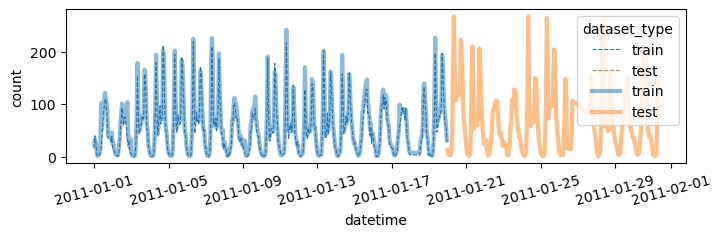

In [26]:
auto(df_train, df_test)

> 랜덤포레스트만 적합했다.

* 개별 모형에 대한 이해

In [ ]:
{
    "NN_TORCH": {},
    "GBM": [
        {"extra_trees": True, "ag_args": {"name_suffix": "XT"}},
        {},
        "GBMLarge"
    ],
    "CAT": {},
    "XGB": {},
    "FASTAI": {},
    "RF": [
        {"criterion": "gini", "ag_args": {"name_suffix": "Gini", "problem_types": ["binary", "multiclass"]}},
        {"criterion": "entropy", "ag_args": {"name_suffix": "Entr", "problem_types": ["binary", "multiclass"]}},
        {"criterion": "squared_error", "ag_args": {"name_suffix": "MSE", "problem_types": ["regression"]}}
    ],
    "XT": [
        {"criterion": "gini", "ag_args": {"name_suffix": "Gini", "problem_types": ["binary", "multiclass"]}},
        {"criterion": "entropy", "ag_args": {"name_suffix": "Entr", "problem_types": ["binary", "multiclass"]}},
        {"criterion": "squared_error", "ag_args": {"name_suffix": "MSE", "problem_types": ["regression"]}}
    ],
    "KNN": [
        {"weights": "uniform", "ag_args": {"name_suffix": "Unif"}},
        {"weights": "distance", "ag_args": {"name_suffix": "Dist"}}
    ]
}

In [28]:
def fit_predict(df_train_featured, df_test_featured):
    """
    특정 모형만 적합하거나 하이퍼파라메터를 튜닝해야 할 때 해당 함수를 변경할 것
    """
    # step1 
    # step2
    predictr= TabularPredictor(label='count',verbosity=False)
    # step3 + 하이퍼파라메터 조정
    hp = {
        "GBM": [
            {"extra_trees": True, "ag_args": {"name_suffix": "XT"}},
            {},
            "GBMLarge"
        ],
        "RF": [
            {"criterion": "gini", "ag_args": {"name_suffix": "Gini", "problem_types": ["binary", "multiclass"]}},
            {"criterion": "entropy", "ag_args": {"name_suffix": "Entr", "problem_types": ["binary", "multiclass"]}},
            {"criterion": "squared_error", "ag_args": {"name_suffix": "MSE", "problem_types": ["regression"]}}
        ],
        "XT": [
            {"criterion": "gini", "ag_args": {"name_suffix": "Gini", "problem_types": ["binary", "multiclass"]}},
            {"criterion": "entropy", "ag_args": {"name_suffix": "Entr", "problem_types": ["binary", "multiclass"]}},
            {"criterion": "squared_error", "ag_args": {"name_suffix": "MSE", "problem_types": ["regression"]}}
        ]
    }
    predictr.fit(
        df_train_featured,
        hyperparameters = hp ## 직접 지정해줄 수 있음
    )
    # step4 
    yhat = predictr.predict(df_train_featured)
    yyhat = predictr.predict(df_test_featured)
    # display
    display(predictr.leaderboard())
    return yhat, yyhat 

`GBM` : 하나의 리스트, 세 개의 딕셔너리

`RF`(랜덤포레스트), `XT`(XGBoost) : `problem_type`에 따라 돌아가는 모형이 다름.(회귀 문제의 경우 하나씩만 돌아감)

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-0.355721,root_mean_squared_error,0.038789,61.144178,0.000293,0.109462,2,True,6
1,LightGBMLarge,-0.360918,root_mean_squared_error,0.022120,24.254390,0.022120,24.254390,1,True,5
2,LightGBM,-0.365194,root_mean_squared_error,0.004990,10.806594,0.004990,10.806594,1,True,2
3,LightGBMXT,-0.373759,root_mean_squared_error,0.011386,25.973732,0.011386,25.973732,1,True,1
4,ExtraTreesMSE,-0.400307,root_mean_squared_error,0.059760,0.488793,0.059760,0.488793,1,True,4
5,RandomForestMSE,-0.401983,root_mean_squared_error,0.060450,0.570090,0.060450,0.570090,1,True,3


100%|████████████████████████████████████████| 242k/242k [00:02<00:00, 93.2kB/s]
Successfully submitted to Bike Sharing Demand

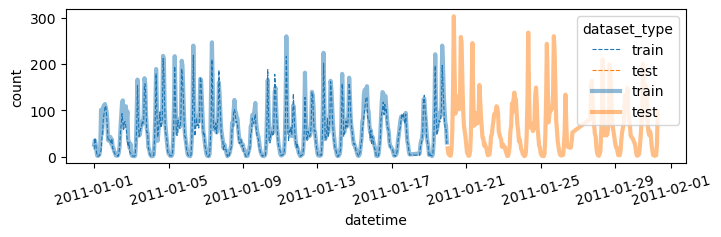

In [29]:
auto(df_train, df_test)

`-` 하나만 두고 돌아가게끔

In [30]:
def fit_predict(df_train_featured, df_test_featured):
    """
    특정 모형만 적합하거나 하이퍼파라메터를 튜닝해야 할 때 해당 함수를 변경할 것
    """
    # step1 
    # step2
    predictr= TabularPredictor(label='count',verbosity=False)
    # step3 + 하이퍼파라메터 조정
    hp = {
        "RF": [
            {"criterion": "squared_error", "ag_args": {"name_suffix": "MSE", "problem_types": ["regression"]}}
        ]
    }
    predictr.fit(
        df_train_featured,
        hyperparameters = hp ## 직접 지정해줄 수 있음
    )
    # step4 
    yhat = predictr.predict(df_train_featured)
    yyhat = predictr.predict(df_test_featured)
    # display
    display(predictr.leaderboard())
    return yhat, yyhat 

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,RandomForestMSE,-0.401983,root_mean_squared_error,0.060802,0.569389,0.060802,0.569389,1,True,1
1,WeightedEnsemble_L2,-0.401983,root_mean_squared_error,0.061079,0.571746,0.000277,0.002357,2,True,2


100%|█████████████████████████████████████████| 243k/243k [00:02<00:00, 108kB/s]
Successfully submitted to Bike Sharing Demand

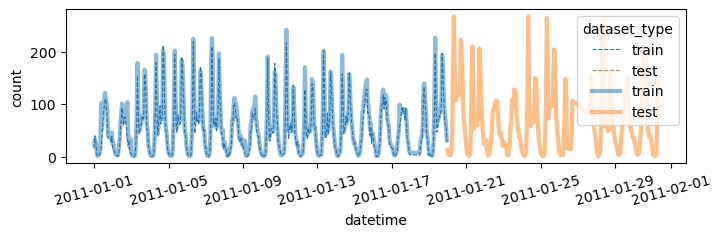

In [31]:
auto(df_train, df_test)

> 하나만 할당했음에도 두 모형이 나옴.

`WeightedEnsemble_L2` : 적합한 모형들의 결과를 합쳐서 만든 메타모형이므로, 무조건 하나가 더 나온다. 보통 스코어가 가장 높게 나오지만, 모형이 하나밖에 없으니까 두 수치가 다르지 않다.

`-` 각 모형들이 뭔지, 하이퍼파라메터를 넣는 방법은 뭔지 알아보려면?

* ref: https://auto.gluon.ai/0.8.1/api/autogluon.tabular.models.html

* LightGBM model: https://lightgbm.readthedocs.io/en/latest/

* CatBoost model: https://catboost.ai/

* XGBoost model: https://xgboost.readthedocs.io/en/latest/
  
* Random Forest model (scikit-learn): https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
* Extra Trees model (scikit-learn): https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier
* Linear model (scikit-learn): https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

`-` 방금 돌린 것은 아래와 결과가 동일함

In [32]:
def fit_predict(df_train_featured, df_test_featured):
    # step1 
    # step2
    predictr= TabularPredictor(label='count',verbosity=False)
    # step3 
    hp = {
        "RF": [
            {"n_estimators":300, "criterion": "squared_error", "ag_args": {"name_suffix": "MSE", "problem_types": ["regression"]}}
        ]
    } ## n_estimators를 300으로 설정
    predictr.fit(
        df_train_featured,
        hyperparameters = hp
    )
    # step4 
    yhat = predictr.predict(df_train_featured)
    yyhat = predictr.predict(df_test_featured)
    # display
    display(predictr.leaderboard())
    return yhat, yyhat 

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,RandomForestMSE,-0.401983,root_mean_squared_error,0.060638,0.580327,0.060638,0.580327,1,True,1
1,WeightedEnsemble_L2,-0.401983,root_mean_squared_error,0.060915,0.582666,0.000277,0.002340,2,True,2


100%|████████████████████████████████████████| 243k/243k [00:02<00:00, 98.9kB/s]
Successfully submitted to Bike Sharing Demand

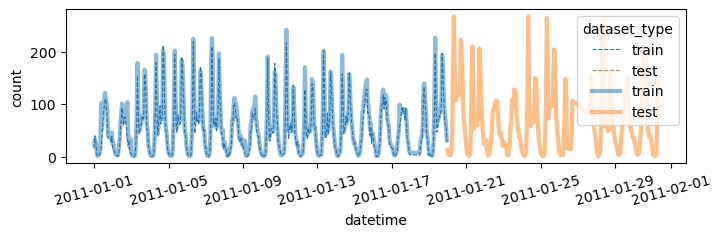

In [33]:
auto(df_train, df_test)

> 어떻게 해당 수치를 알아냈음???(`predictr` 뜯어보면 됨)

In [40]:
df_train_featured, df_test_featured = preprocessing(df_train, df_test)  ## 로그변환하는 함수

In [41]:
predictr = TabularPredictor(label = 'count', verbosity = False)

hp = {
    "RF": [
        {"criterion": "squared_error", "ag_args": {"name_suffix": "MSE", "problem_types": ["regression"]}}
    ]
}

predictr.fit(
    df_train_featured,
    hyperparameters = hp
)

In [48]:
predictr.info()['model_info']['RandomForestMSE']['hyperparameters']

{'n_estimators': 300,
 'max_leaf_nodes': 15000,
 'n_jobs': -1,
 'random_state': 0,
 'bootstrap': True,
 'criterion': 'squared_error'}

> 하이퍼파라메터에 해당하는 부분에서 `n_estimators`가 300인 것을 확인했다.(나무가 300개이고 `max_feature`는 디폴트네? 그럼 그냥 배깅 아님?)

`-` `RF`에서 더 다양한 파라메터를 시험해보자.

In [52]:
[ {"criterion": "squared_error", "n_estimators":i, "max_leaf_nodes":j, "ag_args": {"name_suffix": f"({i},{j})"}} for i in [300,400,500] for j in [10000,15000]]

[{'criterion': 'squared_error',
  'n_estimators': 300,
  'max_leaf_nodes': 10000,
  'ag_args': {'name_suffix': '(300,10000)'}},
 {'criterion': 'squared_error',
  'n_estimators': 300,
  'max_leaf_nodes': 15000,
  'ag_args': {'name_suffix': '(300,15000)'}},
 {'criterion': 'squared_error',
  'n_estimators': 400,
  'max_leaf_nodes': 10000,
  'ag_args': {'name_suffix': '(400,10000)'}},
 {'criterion': 'squared_error',
  'n_estimators': 400,
  'max_leaf_nodes': 15000,
  'ag_args': {'name_suffix': '(400,15000)'}},
 {'criterion': 'squared_error',
  'n_estimators': 500,
  'max_leaf_nodes': 10000,
  'ag_args': {'name_suffix': '(500,10000)'}},
 {'criterion': 'squared_error',
  'n_estimators': 500,
  'max_leaf_nodes': 15000,
  'ag_args': {'name_suffix': '(500,15000)'}}]

> 딕셔너리를 원소로 하는 리스트를 컴프리헨션함

In [50]:
def fit_predict(df_train_featured, df_test_featured):
    # step1 
    # step2
    predictr= TabularPredictor(label='count',verbosity=False)
    # step3 
    hp = {
        "RF": [ {"criterion": "squared_error", "n_estimators":i, "max_leaf_nodes":j, "ag_args": {"name_suffix": f"({i},{j})"}} for i in [300,400,500] for j in [10000,15000]]
    }  ## estimators(트리의 수)를 300, 400, 500, max_leaf_nodes(하위 노드의 최대치)를 10000, 15000으로 잡았을 때
    predictr.fit(
        df_train_featured,
        hyperparameters = hp
    )
    # step4 
    yhat = predictr.predict(df_train_featured)
    yyhat = predictr.predict(df_test_featured)
    # display
    display(predictr.leaderboard())
    return yhat, yyhat 

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,"RandomForest(500,10000)",-0.401733,root_mean_squared_error,0.091952,0.809355,0.091952,0.809355,1,True,5
1,WeightedEnsemble_L2,-0.401733,root_mean_squared_error,0.092248,0.914561,0.000296,0.105206,2,True,7
2,"RandomForest(500,15000)",-0.401733,root_mean_squared_error,0.092573,0.801620,0.092573,0.801620,1,True,6
3,"RandomForest(300,10000)",-0.401983,root_mean_squared_error,0.060530,0.519736,0.060530,0.519736,1,True,1
4,"RandomForest(300,15000)",-0.401983,root_mean_squared_error,0.061099,0.511165,0.061099,0.511165,1,True,2
5,"RandomForest(400,15000)",-0.402192,root_mean_squared_error,0.080701,0.665429,0.080701,0.665429,1,True,4
6,"RandomForest(400,10000)",-0.402192,root_mean_squared_error,0.092283,0.650229,0.092283,0.650229,1,True,3


100%|█████████████████████████████████████████| 242k/242k [00:01<00:00, 126kB/s]
Successfully submitted to Bike Sharing Demand

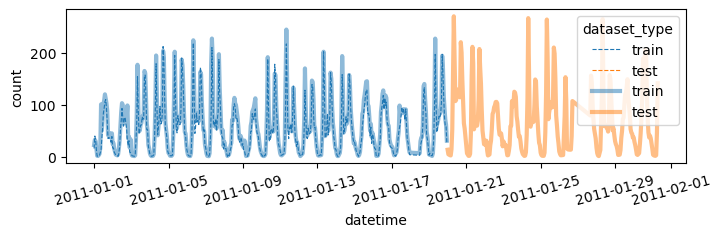

In [51]:
auto(df_train, df_test)

> 이렇게 파라메터 별로 스코어를 비교할 수도 있게 된다.